# C02 Emissions-Modelling Data

In [371]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import random
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression 

In [372]:
df=pd.read_csv('df.csv', index_col=False)

In [373]:
#df.pop("Unnamed: 0")

In [374]:
#converting the categorical data into dummy variables
df_dummy=pd.get_dummies(df, prefix='', prefix_sep='',columns=['Fuel Type','Transmission_Type'])

In [375]:
df_dummy.head(1)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),CO2 Emissions(g/km),DIESEL,ETHANOL,NATURAL GAS,PREMIUM GASOLINE,REGULAR GASOLINE,Automatic,Manual
0,ACURA,ILX,COMPACT,2.0,4,AS5,9.9,6.7,8.5,196,0,0,0,1,0,1,0


In [376]:
#to avoid the duplication of data, dropping one unique column for each categorical feature.
df_dummy.drop(['REGULAR GASOLINE','Manual'],inplace=True,axis=1)

## Linear Regression Model

In [377]:
#defining the X and y variable
X = df_dummy[['DIESEL','ETHANOL','NATURAL GAS','PREMIUM GASOLINE','Engine Size(L)','Cylinders','Automatic']]
y = df_dummy["CO2 Emissions(g/km)"]

In [378]:
#splitting the X and y dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [379]:
#to avoid bias in the data outcome, we are standardizing the data by scaling it
from sklearn.preprocessing import StandardScaler

In [380]:
scaler = StandardScaler()

In [381]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [382]:
reg_all=LinearRegression()
reg_all.fit(scaled_X_train,y_train)

LinearRegression()

In [383]:
print(X_train.shape, y_train.shape)
print(scaled_X_test.shape, y_test.shape)

(4193, 7) (4193,)
(1798, 7) (1798,)


In [384]:
linear_y_pred=reg_all.predict(scaled_X_test)
linear_y_pred

array([205.39409838, 262.1195004 , 215.92134634, ..., 301.81418803,
       354.45042784, 209.41787993])

In [385]:
print('Accuracy of linear regression on test set: {:.2f}'.format(reg_all.score(scaled_X_test, y_test)))

Accuracy of linear regression on test set: 0.75


In [386]:
regression_score=(reg_all.score(scaled_X_test, y_test))

In [387]:
#finding the residuals
test_res = y_test - y_pred
type(test_res)

pandas.core.series.Series

In [388]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [389]:
#Mean Squared Error, Root Mean Squared Error
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

In [390]:
MAE,RMSE

(18.502558411151725, 25.021573071218008)

## Cross-validation:

In [391]:
#Cross-validation used to estimate the skill of a machine learning model on unseen data
#results in less-bias
from sklearn.model_selection import cross_val_score, KFold

In [392]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)
reg=LinearRegression()

In [393]:
cv_results=cross_val_score(reg,X,y,cv=kf)
print(cv_results)

[0.75589225 0.72442665 0.74155752 0.74935762 0.7511444 ]


In [394]:
print(np.mean(cv_results),np.std(cv_results))

0.7444756873832603 0.011037414028931054


In [395]:
print(np.quantile(cv_results,[0.025,0.975]))

[0.72613974 0.75541747]


## Ridge Regression

In [396]:
from sklearn.linear_model import Ridge

In [397]:
#ridge regression model with hyperparameter tuning
ridge_model = Ridge(alpha=0.1)

In [398]:
ridge_model.fit(X_train,y_train)

Ridge(alpha=0.1)

In [399]:
test_predictions = ridge_model.predict(X_test)

In [400]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [401]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [402]:
MAE,RMSE

(22.992510776338424, 30.17836228754734)

In [403]:
print('Accuracy of ridge regression on test set: {:.2f}'.format(ridge_model.score(X_test, y_test)))

Accuracy of ridge regression on test set: 0.75


In [404]:
from sklearn.linear_model import RidgeCV

In [405]:
#penalty strength parameter as alpha
ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0,20.0),scoring='neg_mean_absolute_error')

In [406]:
#k-fold cross validation fit to the training dataset
ridge_cv_model.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. , 20. ]),
        scoring='neg_mean_absolute_error')

In [407]:
#optimal alpha
ridge_cv_model.alpha_

10.0

In [408]:
ridge_test_predictions = ridge_cv_model.predict(X_test)
ridge_test_predictions

array([205.47308574, 262.14036573, 215.90030753, ..., 301.89059613,
       354.0267051 , 209.41047975])

In [409]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [410]:
MAE,RMSE

(22.992510776338424, 30.17836228754734)

In [411]:
ridge_cv_model.coef_

array([ 9.41002256, -7.04529021,  0.        ,  3.93739401, 26.06805448,
        8.78259913,  0.17411884])

In [412]:
print('Accuracy of ridge regression on test set: {:.2f}'.format(ridge_cv_model.score(X_test, y_test)))

Accuracy of ridge regression on test set: 0.75


In [413]:
ridge_score=ridge_cv_model.score(X_test, y_test)

## Lasso Regression

In [414]:
from sklearn.linear_model import LassoCV

In [415]:
lasso_cv_model = LassoCV(eps=0.1,n_alphas=10,cv=5)

In [416]:
lasso_cv_model.fit(X_train,y_train)

LassoCV(cv=5, eps=0.1, n_alphas=10)

In [417]:
lasso_cv_model.alpha_

8.969859393948726

In [418]:
test_predictions = lasso_cv_model.predict(X_test)

In [419]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [420]:
MAE,RMSE

(23.302243923594848, 31.30641740608961)

In [421]:
lasso_cv_model.coef_

array([ 0.        , -0.        ,  0.        ,  0.        , 13.38574599,
       14.87839714,  0.        ])

In [422]:
lasso_test_predictions=lasso_cv_model.predict(X_test)
lasso_test_predictions

array([211.82061376, 261.65602703, 217.17491215, ..., 300.78284351,
       327.55433549, 211.82061376])

In [423]:
print('Accuracy of lasso regression on test set: {:.2f}'.format(lasso_cv_model.score(X_test, y_test)))

Accuracy of lasso regression on test set: 0.73


In [424]:
lasso_score=lasso_cv_model.score(X_test, y_test)

## Elastic Net Regression

In [425]:
from sklearn.linear_model import ElasticNetCV

In [426]:
#improve the regularization by combining lasso and ridge regression
#minimize the RSS(residual sum of squares) and the absolute and squared value terms(absolute for lasso and square for ridge)
elastic_model = ElasticNetCV(l1_ratio=[.1, .5, .7,.9, .95],tol=0.01)

In [427]:
elastic_model.fit(X_train,y_train)

ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95], tol=0.01)

In [428]:
elastic_model.l1_ratio_

0.95

In [429]:
elastic_test_predictions = elastic_model.predict(X_test)
elastic_test_predictions

array([205.63801964, 262.23844782, 216.16354298, ..., 301.44590669,
       354.0735234 , 209.29609702])

In [430]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [431]:
MAE,RMSE

(23.302243923594848, 31.30641740608961)

In [432]:
# Training Set Performance
train_predictions = elastic_model.predict(X_train)
MAE = mean_absolute_error(y_train,train_predictions)
MAE

22.79813619589989

In [433]:
elastic_model.coef_

array([ 5.33256663, -5.38216439,  0.        ,  3.65807738, 26.31380835,
        8.56485782,  0.        ])

In [434]:
print('Accuracy of elestic regression on test set: {:.2f}'.format(elastic_model.score(X_test, y_test)))

Accuracy of elestic regression on test set: 0.75


In [435]:
elastic_score=elastic_model.score(X_test, y_test)

## KNN Regression

In [436]:
from sklearn.neighbors import KNeighborsRegressor

Text(0.5, 1.0, 'ELBOW PLOT')

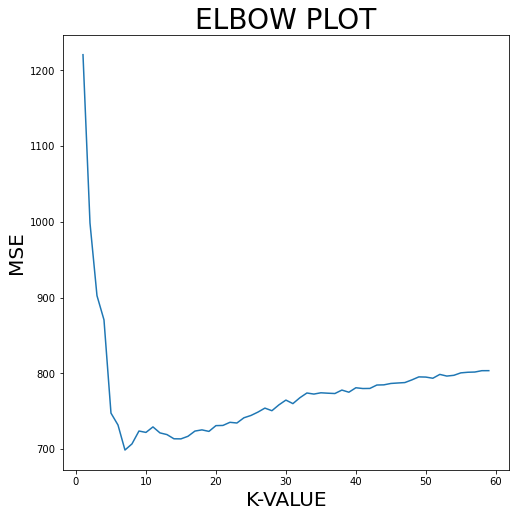

In [437]:
#Elbow plot to determine the optimal value of K that yields lowest MSE
fig,ax=plt.subplots(figsize=(8,8))
k_list=np.arange(1,60,1)
knn_dict={} # To store k and mse pairs
for i in k_list:
#Knn Model Creation
    knn=KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn.fit(X_train,y_train)
    y_knn_pred=model_knn.predict(X_test)
#Storing MSE 
    mse=mean_squared_error(y_test,y_knn_pred)
    knn_dict[i]=mse
#Plotting the results
ax.plot(knn_dict.keys(),knn_dict.values())
ax.set_xlabel('K-VALUE', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)
ax.set_title('ELBOW PLOT' ,fontsize=28)

In [438]:
knn=KNeighborsRegressor(n_neighbors=7)

In [439]:
model_knn=knn.fit(X_train,y_train)
knn_test_predictions=model_knn.predict(X_test)
knn_test_predictions

array([214.85714286, 269.71428571, 222.57142857, ..., 308.42857143,
       324.42857143, 219.        ])

In [440]:
MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [441]:
MAE,RMSE

(23.302243923594848, 31.30641740608961)

In [442]:
print('Accuracy of knn regressor on test set: {:.2f}'.format(model_knn.score(X_test, y_test)))

Accuracy of knn regressor on test set: 0.81


In [443]:
knn_score=model_knn.score(X_test, y_test)

## Support Vector Regression

In [444]:
#create a hypothetical hyperplane that maximizes the margin
#choose linear kernel
from sklearn.svm import SVR

In [445]:
base_model = SVR()

In [529]:
base_model.fit(scaled_X_train,y_train)

SVR()

In [530]:
base_preds = base_model.predict(scaled_X_test)

In [531]:
mean_absolute_error(y_test,base_preds)

23.42771761198186

In [532]:
np.sqrt(mean_squared_error(y_test,base_preds))

32.10741245024187

In [533]:
param_grid = {'C':[10, 100,200],
             'kernel':['linear'],
              'degree':[2,3,4],
              'gamma':[1,0.1,0.01],
              'epsilon':[0.1,0.5,1]}

In [534]:
from sklearn.model_selection import GridSearchCV

In [535]:
svr = SVR()
grid_model = GridSearchCV(estimator=svr,param_grid=param_grid,scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2)

In [536]:
grid_model.fit(scaled_X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.1, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0.1, gamma=0.01, kernel=linear; total time=   0.5s
[CV] END C=10, degree=2, epsilon=0

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [10, 100, 200], 'degree': [2, 3, 4],
                         'epsilon': [0.1, 0.5, 1], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             scoring='neg_mean_squared_error', verbose=2)

In [525]:
grid_model.best_estimator_

DecisionTreeRegressor(max_depth=12, random_state=42)

In [527]:
svm=SVR(C=100,degree=2,epsilon=0.5,kernel='linear')
svm_model=svm.fit(scaled_X_train,y_train)
result=svm.predict(X_test)

In [528]:
svm_model_predict=svm_model.predict(scaled_X_test)
svm_model_predict

array([206.15800521, 260.02980634, 217.2503709 , ..., 297.05275197,
       352.51458044, 211.49388109])

In [457]:
print('Accuracy of SVM regression on test set: {:.2f}'.format(svm_model.score(scaled_X_test, y_test)))

Accuracy of SVM regression on test set: 0.75


In [458]:
MAE = mean_absolute_error(y_test,result)
MSE = mean_squared_error(y_test,result)
RMSE = np.sqrt(MSE)

In [459]:
MAE,RMSE

(22.670419890094117, 30.218486080237692)

In [460]:
svm_model=svm_model.score(scaled_X_test, y_test)

## Regression Tree

In [461]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 42)

In [462]:
model=regressor.fit(X_train,y_train)

In [463]:
model.score(X_test, y_test)

0.8293812478108182

In [464]:
y_test_pred = model.predict(X_test)

In [465]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_test_pred)

18.49124792728084

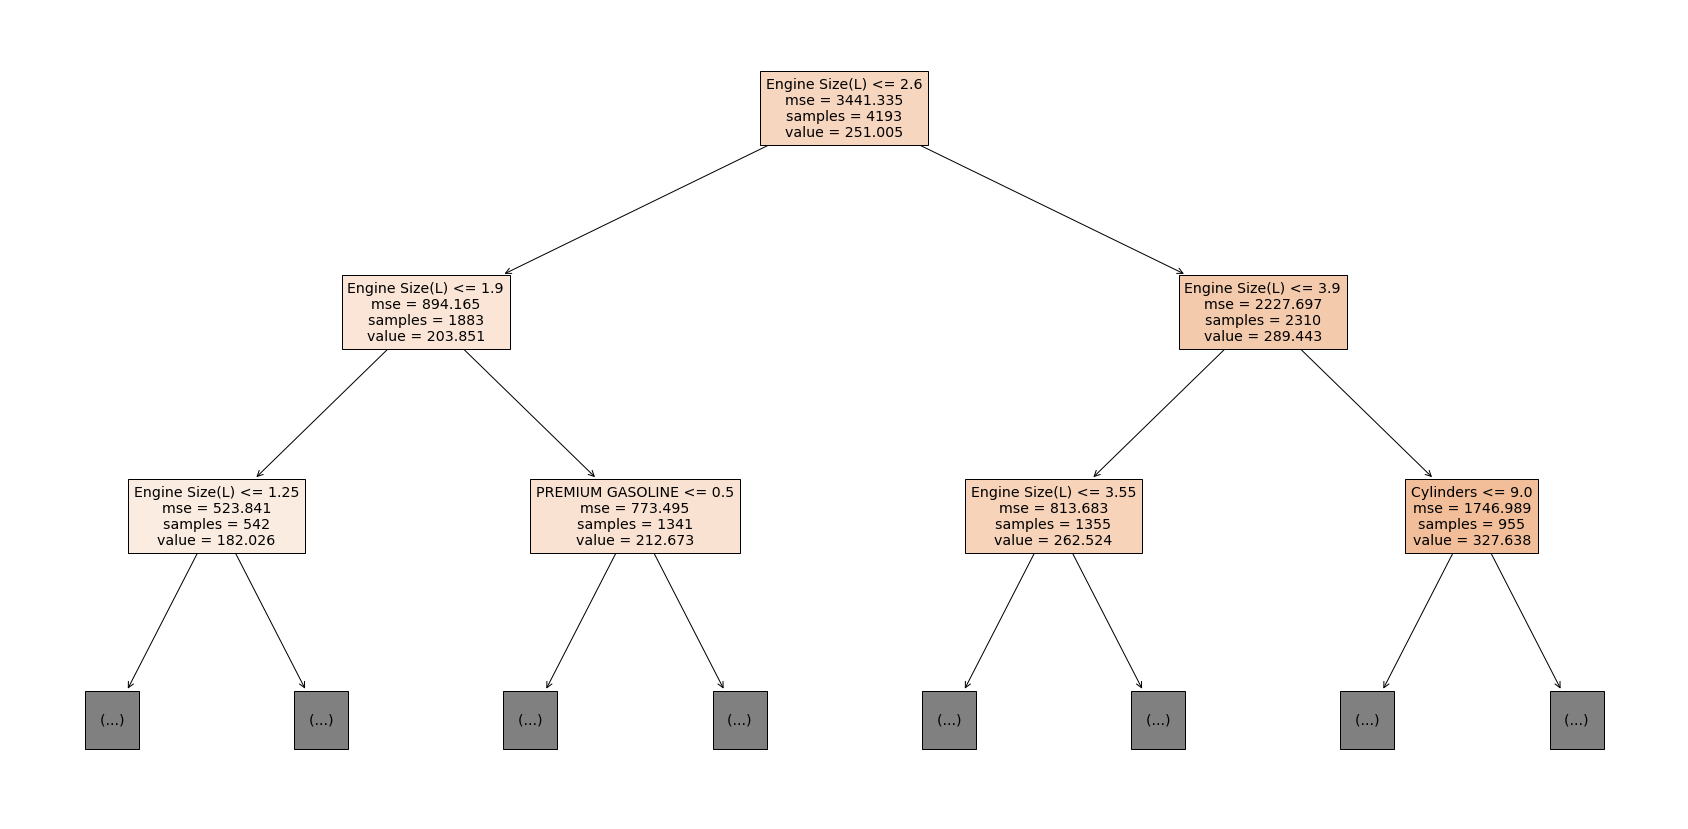

In [466]:
plt.figure(figsize = (30,15))
from sklearn import tree
tree.plot_tree(model, 
               feature_names = list(X_train.columns), 
               filled = True,
               max_depth = 2);

In [467]:
importance = model.feature_importances_
importance

array([4.36439393e-04, 3.22768412e-03, 0.00000000e+00, 1.61663767e-02,
       9.35024844e-01, 3.72502044e-02, 7.89445160e-03])

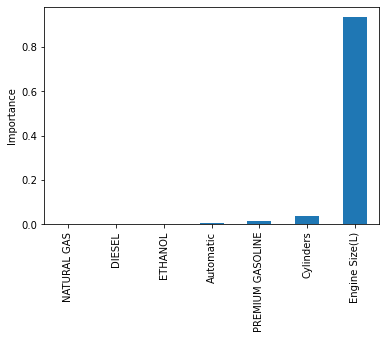

In [468]:
feature_importance = pd.Series(importance, index = X_train.columns)
feature_importance.sort_values().plot(kind = 'bar')
plt.ylabel('Importance');

The most important feature is Engine Size(L) for this model.

In [469]:
model.score(X_train, y_train)

0.8220720697447578

In [470]:
model.score(X_test, y_test)

0.8293812478108182

No pruning required as the model score for the train and testing set is same. This means there is no overfitting or underfitting of the data on the decision tree regression model.


In [471]:
tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

In [472]:
grid_model = GridSearchCV(estimator=regressor,param_grid=tree_param,scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=2)

In [473]:
model=grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=4; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ........................................max_depth=6; total time=   0.0s
[CV] END .......................................

In [541]:
y_test_pred = grid_model.predict(X_test)

In [542]:
grid_model.best_estimator_

SVR(C=100, degree=2, epsilon=0.5, gamma=1, kernel='linear')

In [543]:
regressor = DecisionTreeRegressor(random_state = 42,max_depth=12)

In [544]:
model2=regressor.fit(X_train,y_train)

In [545]:
regression_tree_pred=model2.predict(X_test)
regression_tree_pred

array([202.88847584, 269.93413174, 218.60264901, ..., 316.33333333,
       333.15      , 217.90981432])

In [546]:
model2.score(X_test, y_test)

0.8293812478108182

In [549]:
mean_absolute_error(y_test, regression_tree_pred)

18.49124792728084

In [551]:
model2_score=model2.score(X_test, y_test)
model2_score

0.8293812478108182

## GRADIENT BOOSTING

In [482]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbModel = GradientBoostingRegressor()
gbModel.fit(X_train, y_train)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(gbModel, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -20.180 (1.208)


>10 -25.935 (1.574)
>20 -21.759 (1.282)
>30 -21.041 (1.184)
>40 -20.707 (1.194)
>50 -20.523 (1.191)
>60 -20.424 (1.200)
>70 -20.340 (1.211)
>80 -20.284 (1.212)
>90 -20.227 (1.210)
>100 -20.175 (1.212)
>200 -19.650 (1.261)
>500 -19.213 (1.392)
>600 -19.175 (1.389)


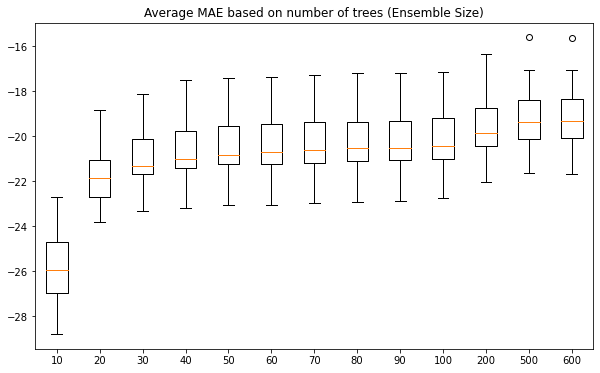

In [483]:
def get_models():
    models = dict()
    n_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,200,500,600]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n)
        models[str(n)].fit(X_train,y_train)
    return models

def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

fig,ax = fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.boxplot(results, labels=names)
plt.title('Average MAE based on number of trees (Ensemble Size)')
plt.show();

In [484]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

gbModel_best = GradientBoostingRegressor(n_estimators=500)
gbModel_best.fit(X_train, y_train)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gbModel_best, X_test, y_test, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -19.214 (1.395)


In [485]:
from sklearn.model_selection import GridSearchCV

In [486]:
param_grid = {"n_estimators":[1,5,10,20,40,100,200,300,500],'max_depth':[3,4,5,6,8]}

In [487]:
gb_model = GradientBoostingRegressor()

In [488]:
grid_gb_model = GridSearchCV(gb_model,param_grid)

In [489]:
grid_gb_model.fit(X_train,y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 4, 5, 6, 8],
                         'n_estimators': [1, 5, 10, 20, 40, 100, 200, 300,
                                          500]})

In [490]:
grid_gb_model.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [491]:
gb_model_predictions = grid_gb_model.predict(X_test)

In [492]:
gb_model_predictions

array([202.84107158, 269.90282763, 218.52545466, ..., 316.39325077,
       333.17512656, 217.91858161])

In [493]:
grid_gb_model.best_estimator_.feature_importances_

array([2.71550731e-04, 2.86365186e-03, 0.00000000e+00, 1.56143550e-02,
       9.36887149e-01, 3.73121712e-02, 7.05112187e-03])

In [494]:
feat_import = grid_gb_model.best_estimator_.feature_importances_
feat_import

array([2.71550731e-04, 2.86365186e-03, 0.00000000e+00, 1.56143550e-02,
       9.36887149e-01, 3.73121712e-02, 7.05112187e-03])

In [495]:
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])

In [496]:
imp_feats.sort_values(by='Importance')

,Importance
NATURAL GAS,0.000000
DIESEL,0.000272
ETHANOL,0.002864
Automatic,0.007051
PREMIUM GASOLINE,0.015614
Cylinders,0.037312
Engine Size(L),0.936887


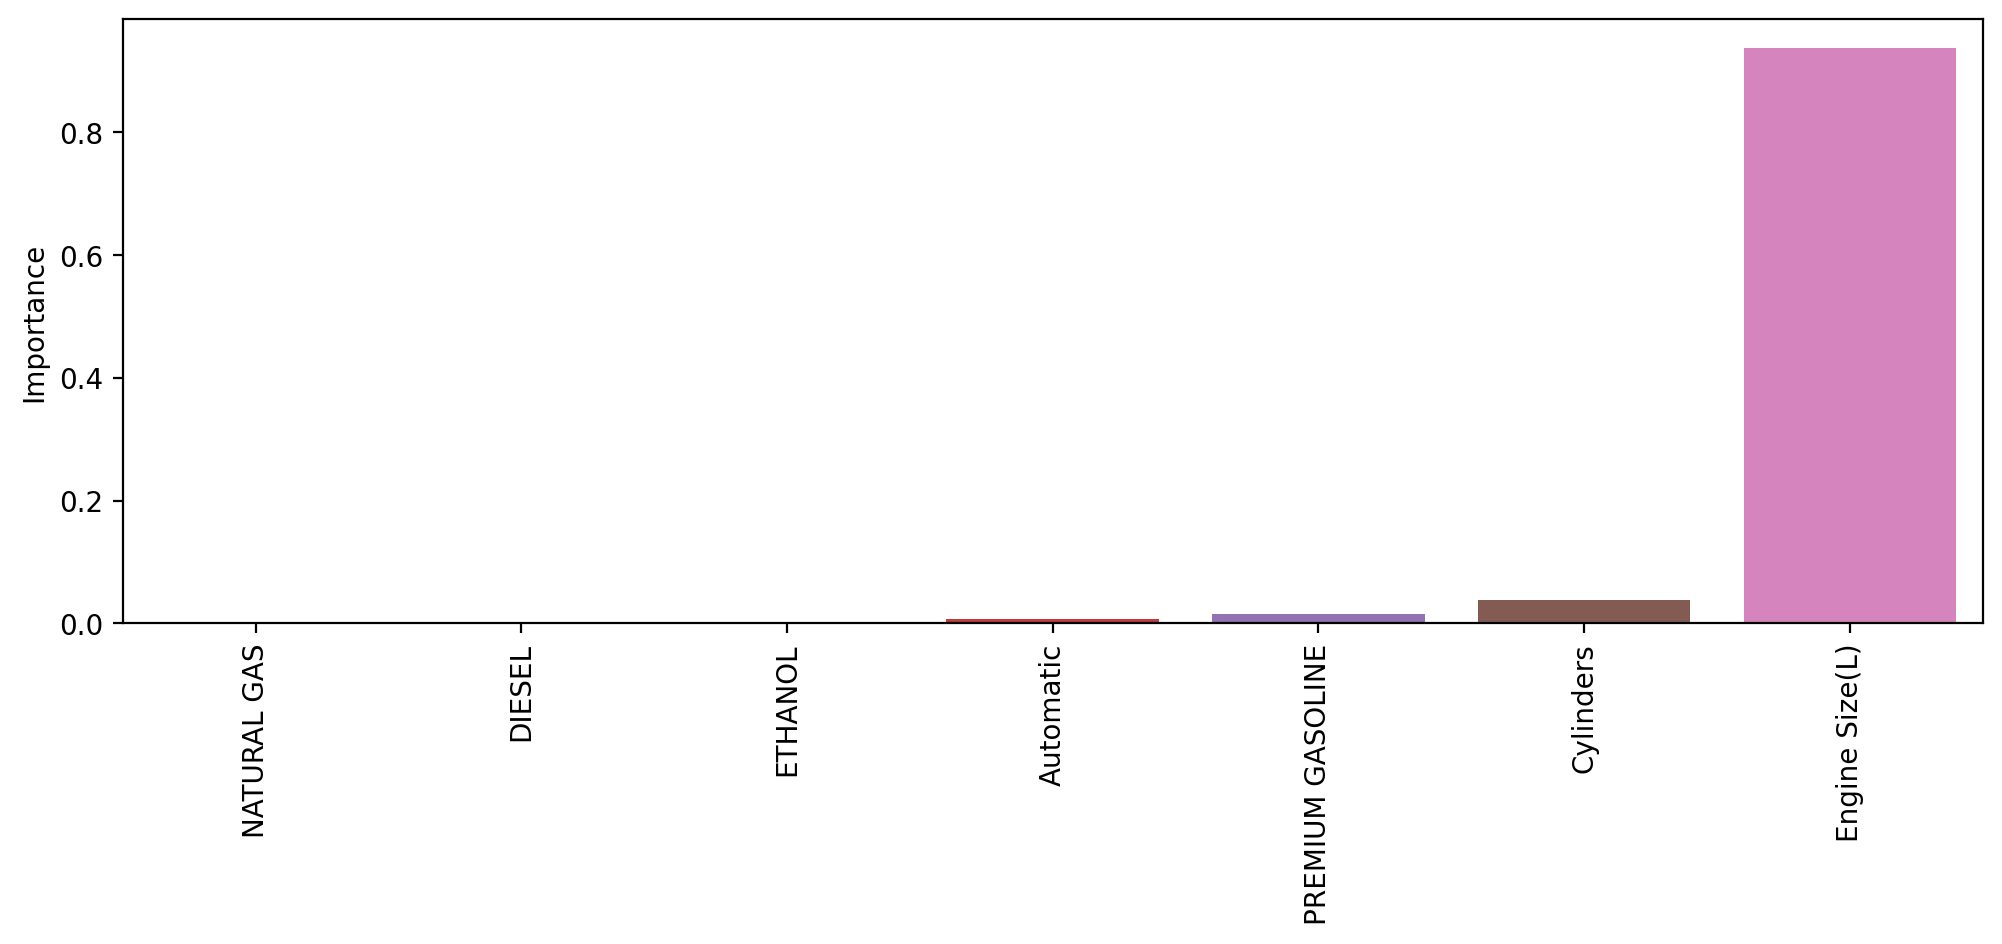

In [538]:
plt.figure(figsize=(12,4),dpi=200)
sns.barplot(data=imp_feats.sort_values(by='Importance'),x=imp_feats.sort_values(by='Importance').index,y='Importance')

plt.xticks(rotation=90);
plt.savefig('important_features.png')

Engine Size(L) is the most important feature for predicting CO2 Emissions

In [498]:
grid_gb_model.score(X_test, y_test)

0.8284566580536801

In [499]:
gb_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [500]:
gb_model.score(X_test, y_test)

0.8110087878436367

In [501]:
print('Accuracy of GB cross validation regression on test set: {:.2f}'.format(grid_gb_model.score(X_test, y_test)))

Accuracy of GB cross validation regression on test set: 0.83


In [502]:
gradient_boosting=grid_gb_model.score(X_test, y_test)

## Random Forest Regression

In [503]:
from sklearn.ensemble import RandomForestRegressor

In [504]:
rfr_model = RandomForestRegressor().fit(X_train, y_train)

In [505]:
y_pred = rfr_model.predict(X_test)

In [506]:
print('Accuracy of RF regression on test set: {:.2f}'.format(rfr_model.score(X_test, y_test)))

Accuracy of RF regression on test set: 0.83


In [507]:
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)
RMSE = np.sqrt(MSE)

In [508]:
MAE,RMSE

(18.582807233055338, 25.107616148575588)

In [509]:
random_forest=rfr_model.score(X_test, y_test)

## Random Search with Cross Validation

In [510]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [511]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

In [512]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [513]:
rf_random_pred = rf_random.predict(X_test)
rf_random_pred

array([202.88847584, 269.93413174, 218.60264901, ..., 316.33333333,
       333.15      , 217.90981432])

In [514]:
print('Accuracy of RF cross validation regression on test set: {:.2f}'.format(rf_random.score(X_test, y_test)))

Accuracy of RF cross validation regression on test set: 0.83


In [515]:
rf_random_score=rf_random.score(X_test, y_test)

In [516]:
data ={'Model':['linear_regression','ridge_regression', 'lasso_regression','elastic_regression',
                   'knn_regression', 'svm_regression', 'decision_tree_regression','gradient_boosting_regression',
                    'random_forest_regression'],'Model_Score':[regression_score,ridge_score, lasso_score,elastic_score,
                   knn_score, svm_model, decision_tree_score,gradient_boosting,
                    random_forest]}

df_model= pd.DataFrame(data=data);
df_model

,Model,Model_Score
0,linear_regression,0.751553
1,ridge_regression,0.751638
2,lasso_regression,0.732634
3,elastic_regression,0.751755
4,knn_regression,0.809349
5,svm_regression,0.750893
6,decision_tree_regression,0.829381
7,gradient_boosting_regression,0.828457
8,random_forest_regression,0.828031


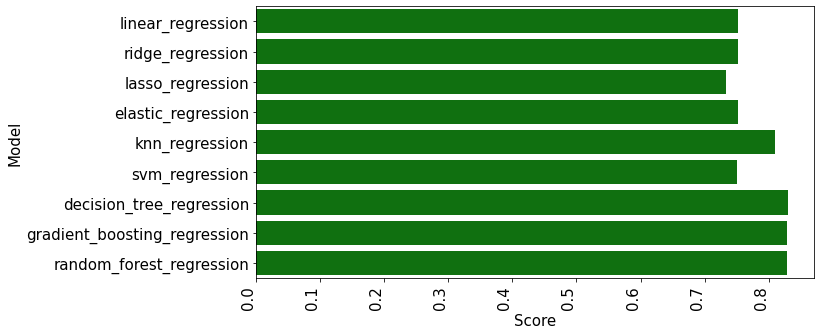

In [573]:
plt.figure(figsize = (10,5))
sns.barplot(data=df_model,x='Model_Score',y='Model',color='g')
plt.ylabel('Model',fontsize=15)
plt.xlabel('Score',fontsize=15)
plt.xticks(fontsize=15,rotation=90,ha='right')
plt.yticks(fontsize=15)
plt.savefig('scores.png')
plt.savefig('scores.png',dpi=300, bbox_inches='tight');

# Testing Each Model Against Predicted Data

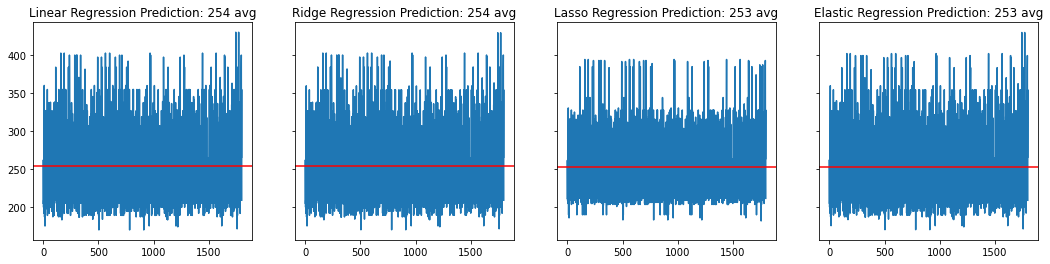

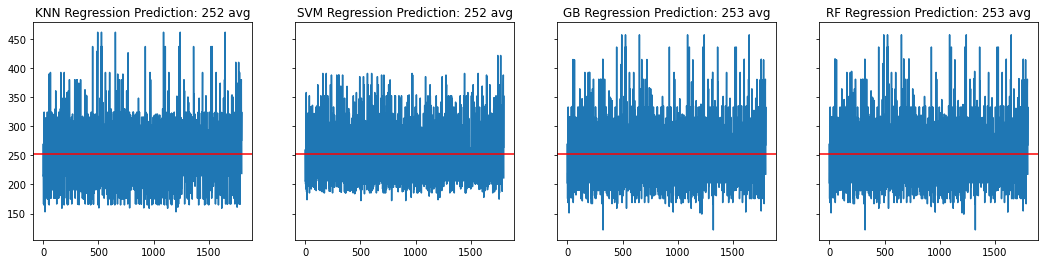

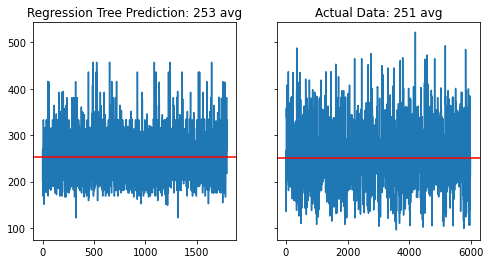

In [568]:
linear_y_pred
ridge_test_predictions
lasso_test_predictions
elastic_test_predictions
knn_test_predictions
svm_model_predict
gb_model_predictions
rf_random_pred
regression_tree_pred
actual_data= df['CO2 Emissions(g/km)']

lr_mean = int(np.mean(linear_y_pred))
ri_mean = int(np.mean(ridge_test_predictions))
las_mean = int(np.mean(lasso_test_predictions))
elas_mean = int(np.mean(elastic_test_predictions))
knn_mean = int(np.mean(knn_test_predictions))
svm_mean = int(np.mean(svm_model_predict))
gb_mean = int(np.mean(gb_model_predictions))
rf_mean = int(np.mean(rf_random_pred))
reg_tree_mean = int(np.mean(regression_tree_pred))
actual_mean=int(np.mean(actual_data))


fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(18,4))
ax[0].plot(linear_y_pred)
ax[0].axhline(y=lr_mean, color='r', linestyle='-')
ax[0].set_title('Linear Regression Prediction: ' + str(lr_mean) + ' avg')
ax[1].plot(ridge_test_predictions)
ax[1].axhline(y=ri_mean, color='r', linestyle='-')
ax[1].set_title('Ridge Regression Prediction: ' + str(ri_mean) + ' avg')
ax[2].plot(lasso_test_predictions)
ax[2].axhline(y=las_mean, color='r', linestyle='-')
ax[2].set_title('Lasso Regression Prediction: ' + str(las_mean) + ' avg')
ax[3].plot(elastic_test_predictions)
ax[3].axhline(y=gb_mean, color='r', linestyle='-')
ax[3].set_title('Elastic Regression Prediction: ' + str(gb_mean) + ' avg')

fig,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize=(18,4))
ax[0].plot(knn_test_predictions)
ax[0].axhline(y=knn_mean, color='r', linestyle='-')
ax[0].set_title('KNN Regression Prediction: ' + str(knn_mean) + ' avg')
ax[1].plot(svm_model_predict)
ax[1].axhline(y=svm_mean, color='r', linestyle='-')
ax[1].set_title('SVM Regression Prediction: ' + str(svm_mean) + ' avg')
ax[2].plot(gb_model_predictions)
ax[2].axhline(y=gb_mean, color='r', linestyle='-')
ax[2].set_title('GB Regression Prediction: ' + str(gb_mean) + ' avg')
ax[3].plot(rf_random_pred)
ax[3].axhline(y=rf_mean, color='r', linestyle='-')
ax[3].set_title('RF Regression Prediction: ' + str(rf_mean) + ' avg')

fig,ax = plt.subplots(1,2,sharex=False,sharey=True,figsize=(8,4))
ax[0].plot(regression_tree_pred)
ax[0].axhline(y=reg_tree_mean, color='r', linestyle='-')
ax[0].set_title('Regression Tree Prediction: ' + str(reg_tree_mean) + ' avg')
ax[1].plot(actual_data)
ax[1].axhline(y=actual_mean, color='r', linestyle='-')
ax[1].set_title('Actual Data: ' + str(actual_mean) + ' avg')


fig.show;


## SUMMARY

From all these models, random forest regression, gradient boosting and decision regression tree produced the best score of 0.83 which shows that these models are best for predicting the carbon dioxide emissions from vehicles.